**Heidelberg University**

**Data Science  Group**
    
Prof. Dr. Michael Gertz  

Ashish Chouhan, Satya Almasian, John Ziegler, Jayson Salazar, Nicolas Reuter
    
October 30, 2023
    
Natural Language Processing with Transformers

Winter Semster 2023/2024     
***

# **Assignment 1: “Word Embeddings and Probabilistic Language Models”**
**Due**: Monday, November 13, 2pm, via [Moodle](https://moodle.uni-heidelberg.de/course/view.php?id=19251)



### **Submission Guidelines**

- Solutions need to be uploaded as a **single** Jupyter notebook. You will find several pre-filled code segments in the notebook, your task is to fill in the missing cells.
- For the written solution, use LaTeX in markdown inside the same notebook. Do **not** hand in a separate file for it.
- Download the .zip file containing the dataset but do **not** upload it with your solution.
- It is sufficient if one person per group uploads the solution to Moodle, but make sure that the complete names of all team members are given in the notebook.

***

## **Task 1: F.R.I.E.N.D.S and  Word2Vec (Grade (2 + 2 + 4) = 8)**

[Friends](https://en.wikipedia.org/wiki/Friends) is an American television sitcom, created by David Crane and Marta Kauffman. In this assignment we will use the transcripts from the show to train a Word2Vec model using the [Gensim](https://radimrehurek.com/gensim/) library.

### Subtask 1: Pre-processing
We start by loading and cleaning the data. Download the dataset for this assignment and load the `friends_quotes.csv` using pandas. The dataset is from Kaggle (https://www.kaggle.com/ryanstonebraker/friends-transcript) and is created for building a classifier that  determines which friend from the Friend's TV Show would be most likely to say a quote. The column `quote` contains a line from the movie and the `author` is the one who said it. Since these are the only two columns we need, we remove the rest and only keep these two columns.

In [105]:
import re
import pandas as pd
from collections import defaultdict
import spacy
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [106]:
df = pd.read_csv("friends_quotes.csv") 
### filter out columns ###
df = df[["author", "quote"]]
df.head(10)

,author,quote
0,Monica,There's nothing to tell! He's just some guy I ...
1,Joey,"C'mon, you're going out with the guy! There's ..."
2,Chandler,"All right Joey, be nice. So does he have a hum..."
3,Phoebe,"Wait, does he eat chalk?"
4,Phoebe,"Just, 'cause, I don't want her to go through w..."
5,Monica,"Okay, everybody relax. This is not even a date..."
6,Chandler,Sounds like a date to me.
7,Chandler,"Alright, so I'm back in high school, I'm stand..."
8,All,"Oh, yeah. Had that dream."
9,Chandler,"Then I look down, and I realize there's a phon..."


Fortunately, there is no missing data, so we do not need to worry about that.

In [107]:
df.isnull().sum() # check for missing data

author    0
quote     0
dtype: int64

Use SpaCy to preprocess the text. For this, perform the following steps:
- lowercase the words
- remove the stopwords and single characters
- use regex to remove non-alphabetic characters (anything that is not a number or alphabet including punctuations), in other words only keep "a" to "z" and digits.
- remove lines that have less than 4 words, since they cannot contribute much to the training process.

Please do not add any additional steps on your own or additional cleaning as we want to achieve comparable results.

In [108]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# lowercase and remove non-alphabetic characters
def preprocess(text):
    # Lowercase and remove non-alphabetic characters
    text = re.sub("[/']", ' ', re.sub("[^A-Za-z\d']+", ' ', text)).lower()
    
    # Remove stopwords and single characters
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords and len(word) > 1]
    
    return ' '.join(filtered_words)


# Remove lines with less than 4 words
# if applied before removing stopwords, removes lines that have in general less than 4 words.
# if applied after preprocessing, lines with more than 4 words but less than 4 after stopword removal would also be removed (like the first line "Monica:	There's nothing to tell! He's just some guy I ...")
df = df[df['quote'].apply(lambda x: len(x.split()) > 3)]

quotes = []  # to save all the lines

for quote in df['quote']:
    processed_quote = preprocess(quote)
    quotes.append(processed_quote)

df['quote'] = quotes 

df = df.reset_index(drop=True)
df.head(10)

,author,quote
0,Monica,tell guy work
1,Joey,mon going guy gotta wrong
2,Chandler,right joey nice hump hump hairpiece
3,Phoebe,wait eat chalk
4,Phoebe,cause don want went carl oh
5,Monica,okay everybody relax date people going dinner ...
6,Chandler,sounds like date
7,Chandler,alright high school standing middle cafeteria ...
8,All,oh yeah dream
9,Chandler,look realize phone


The next step is to build the vocabulary of the words and word combinations we want to learn representations from. We choose a subset of the most frequent words and bigrams to represent our corpus.
- Use the Gensim Phrases package to automatically detect common phrases (bigrams) from a list of lines from the previous step (`min_count=10`). Now words like New_York will be considered as one entity and character names like joey_tribbiani will be recognized.
- Create a list of words/bigrams with their frequencies and choose the top 15.000 words for the vocabulary, in order to keep the computation time-limited and to choose the most important words.

In [109]:
from gensim.models.phrases import Phrases

words = [doc.split(" ") for doc in quotes] #list of all words#
phrases = Phrases(words, min_count=10) #define the phraser for bi-gram creation#
new_lines = phrases[words] #transform the lines#

# for line in new_lines:
#     print(line)

INFO - 21:54:39: collecting all words and their counts
INFO - 21:54:39: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 21:54:39: PROGRESS: at sentence #10000, processed 61061 words and 45967 word types
INFO - 21:54:39: PROGRESS: at sentence #20000, processed 123719 words and 82123 word types
INFO - 21:54:39: PROGRESS: at sentence #30000, processed 187031 words and 114237 word types
INFO - 21:54:39: PROGRESS: at sentence #40000, processed 249630 words and 144236 word types
INFO - 21:54:39: collected 162199 token types (unigram + bigrams) from a corpus of 286578 words and 46148 sentences
INFO - 21:54:39: merged Phrases<162199 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000>
INFO - 21:54:39: Phrases lifecycle event {'msg': 'built Phrases<162199 vocab, min_count=10, threshold=10.0, max_vocab_size=40000000> in 0.16s', 'datetime': '2023-11-10T21:54:39.736351', 'gensim': '4.3.2', 'python': '3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) \n[C

In [110]:
print(new_lines[0], new_lines[199])

['tell', 'guy', 'work'] ['ready', 'ready', 'hey', 'rach', 'ready', 'jump', 'airplane', 'parachute', 'come']


In [111]:
from collections import Counter
### find the top words for the vocabulary###
vocab = [word for line in new_lines for word in line]
#print(vocab[:50])

vocab_counts = Counter(vocab)
print(vocab_counts)

# Sort according to frequency
vocab_sorted = {k: v for k, v in sorted(vocab_counts.items(), key=lambda item:item[1], reverse=True)}
print(len(vocab_sorted))

# Keep only the first 15000 items
word_freq = {k: v for i, (k, v) in enumerate(vocab_sorted.items()) if i < 15000}
print(word_freq)

vocab = list(word_freq.keys())
print(vocab[:10])


Counter({'know': 6765, 'oh': 5865, 'okay': 4174, 'don': 3957, 'yeah': 3822, 'right': 3210, 'like': 3131, 'hey': 2857, 'gonna': 2714, 'ross': 2517, 'uh': 2284, 'look': 2263, 'think': 2253, 'joey': 2234, 'll': 2001, 'chandler': 1981, 'mean': 1942, 'monica': 1842, 'rachel': 1811, 'want': 1698, 'come': 1586, 'got': 1461, 'phoebe': 1411, 'guys': 1402, 'going': 1387, 'good': 1350, 'sorry': 1280, 'let': 1237, 'great': 1202, 'ok': 1197, 'time': 1150, 'little': 1139, 'didn': 1130, 'tell': 1121, 've': 1086, 'oh_god': 1078, 'guy': 1049, 'love': 983, 'thing': 971, 'maybe': 881, 'way': 846, 'umm': 837, 'said': 832, 'hi': 741, 'looks': 727, 'yes': 722, 'wanna': 713, 'believe': 677, 'man': 674, 'people': 672, 'thought': 663, 'wow': 628, 'sure': 617, 'actually': 600, 'need': 592, 'work': 588, 'baby': 576, 'talk': 565, 'listen': 551, 'ah': 546, 'big': 543, 'huh': 538, 'um': 537, 'room': 535, 'starts': 534, 'wait': 532, 'stuff': 517, 'thank': 512, 'doesn': 505, 'goes': 499, 'gotta': 494, 'looking': 486,

In [112]:
word_freq['central_perk']

36

In [113]:
word_freq['joey']

2234

### Subtask 2: Training the Model


Use the Gensim implementation of Word2Vec to train a model on the scripts. The training can be divided into 3 stages:


1) Set up your model with parameters; define your parameters in such a way that the following conditions are satisfied:
 - ignore all words that have a total frequency of less than 2.
 - dimensions of the embeddings: 100
 - initial learning rate (step size) of 0.03
 - 20 negative samples
 - window size 3
 - the learning rate in the training will decrease as you apply more and more updates. Most of the time when starting with gradient descent the initial steps can be larger, and as we get close to the local minima it is best to use smaller steps to avoid jumping over the local minima. This adjustment is done internally using a learning rate scheduler. Make sure that the smallest learning rate does not go below 0.0001.
 - set the threshold for configuring which higher-frequency words are randomly down-sampled to 6e-5. This parameter forces the sampling to choose the very frequent words less often in the sampling.
 - set the hashfunction of the word2vec to the given function.
 - train on a single worker to make sure you get the same result as ours.

In [114]:
from gensim.models import Word2Vec

def hash(astring):
    return ord(astring[0])

w2v = Word2Vec(sentences=new_lines, min_count=2, vector_size=100, alpha=0.03, negative=20, window=3, 
               min_alpha=0.0001, sample=6e-5, hashfxn=hash, workers=1)

INFO - 21:54:40: collecting all words and their counts
INFO - 21:54:40: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:54:40: PROGRESS: at sentence #10000, processed 59443 words, keeping 7747 word types
INFO - 21:54:40: PROGRESS: at sentence #20000, processed 120367 words, keeping 10750 word types
INFO - 21:54:40: PROGRESS: at sentence #30000, processed 181872 words, keeping 12737 word types
INFO - 21:54:40: PROGRESS: at sentence #40000, processed 242629 words, keeping 14685 word types
INFO - 21:54:40: collected 15944 word types from a corpus of 278649 raw words and 46148 sentences
INFO - 21:54:40: Creating a fresh vocabulary
INFO - 21:54:40: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 9378 unique words (58.82% of original 15944, drops 6566)', 'datetime': '2023-11-10T21:54:40.390384', 'gensim': '4.3.2', 'python': '3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) \n[Clang 15.0.7 ]', 'platform': 'macOS-13.5.1-arm64-arm-64bi

2) Before training, Word2Vec requires us to build the vocabulary table by filtering out the unique words and doing some basic counts on them.
Use the `build_vocab` function to process the data. If you look at the logs you can see the effect of `min_count` and `sample` on the word corpus.

In [115]:
w2v.build_vocab(corpus_iterable=new_lines)

INFO - 21:54:43: collecting all words and their counts
INFO - 21:54:43: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 21:54:43: PROGRESS: at sentence #10000, processed 59443 words, keeping 7747 word types
INFO - 21:54:44: PROGRESS: at sentence #20000, processed 120367 words, keeping 10750 word types
INFO - 21:54:44: PROGRESS: at sentence #30000, processed 181872 words, keeping 12737 word types
INFO - 21:54:44: PROGRESS: at sentence #40000, processed 242629 words, keeping 14685 word types
INFO - 21:54:44: collected 15944 word types from a corpus of 278649 raw words and 46148 sentences
INFO - 21:54:44: Creating a fresh vocabulary
INFO - 21:54:44: Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 9378 unique words (58.82% of original 15944, drops 6566)', 'datetime': '2023-11-10T21:54:44.238111', 'gensim': '4.3.2', 'python': '3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) \n[Clang 15.0.7 ]', 'platform': 'macOS-13.5.1-arm64-arm-64bi

3) Finally, we  train the model. Train the model for 100 epochs. This will take a while. As we do not plan to train the model any further, we call `init_sims()`, which will make the model much more memory-efficient by precomputing L2-norms of word weight vectors for further analysis.

In [116]:
w2v.train(corpus_iterable=new_lines, total_examples=w2v.corpus_count, epochs=100)
w2v.init_sims()

WARNING - 21:54:44: Effective 'alpha' higher than previous training cycles
INFO - 21:54:44: Word2Vec lifecycle event {'msg': 'training model with 1 workers on 9378 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=20 window=3 shrink_windows=True', 'datetime': '2023-11-10T21:54:44.299598', 'gensim': '4.3.2', 'python': '3.9.18 | packaged by conda-forge | (main, Aug 30 2023, 03:53:08) \n[Clang 15.0.7 ]', 'platform': 'macOS-13.5.1-arm64-arm-64bit', 'event': 'train'}
INFO - 21:54:44: EPOCH 0: training on 278649 raw words (125272 effective words) took 0.7s, 192018 effective words/s
INFO - 21:54:45: EPOCH 1: training on 278649 raw words (125482 effective words) took 0.7s, 187466 effective words/s
INFO - 21:54:46: EPOCH 2: training on 278649 raw words (125582 effective words) took 0.7s, 181184 effective words/s
INFO - 21:54:47: EPOCH 3: training on 278649 raw words (125582 effective words) took 0.7s, 188577 effective words/s
INFO - 21:54:47: EPOCH 4: training on 278649 raw wor

### Subtask 3: Exploring the Model


As mentioned in the lecture, word embeddings are suited for similarity and analogy tasks. Let's explore some of that with our dataset:

We look for the most similar words to the name of the famous coffee shop where most of the episodes took place, namely `central_perk` and also one of the characters `joey`. If you have followed the exercise correctly until now, you should see that words like `laying` are similar to `central_perk` and the other main characters are also considered similar to `joey`.



In [117]:
wv = w2v.wv

In [118]:
def print_similar_words(target: str) -> None:
    similar_words = [x[0] for x in wv.most_similar(target)]
    print(f"Most similar words to '{target}':\n{similar_words}")

print_similar_words("central_perk")
print_similar_words("joey")

Most similar words to 'central_perk':
['conan', 'sitting_couch', 'recliner', 'aaah', 'village', 'laying', 'rehearsing', 'appartment', 'hippity', 'scene']
Most similar words to 'joey':
['chandler', 'monica', 'rachel', 'ross', 'phoebe', 'looks', 'right', 'goes', 'okay', 'hey']


Look at the similarity of `green` to `rachel` (her lastname) and `ross`  and `spaceship` (urelated). The first one should have a high and the second a low score. Finally, look at the similarity of `smelly_cat` ( a song from pheobe) and `song` the similarity should be high.

In [119]:
print("Similarity between 'green' and 'rachel': " + str(wv.similarity("green", "rachel")))

Similarity between 'green' and 'rachel': 0.089701764


In [120]:
print("Similarity between 'ross' and 'spaceship': " + str(wv.similarity("ross", "spaceship")))

Similarity between 'ross' and 'spaceship': -0.25138822


In [121]:
print("Similarity between 'smelly_cat' and 'song': " + str(wv.similarity("smelly_cat", "song")))

Similarity between 'smelly_cat' and 'song': 0.53209466


We can also ask our model to give us the word that does not belong to a list of words. Let's see from the list of all 5 characters which one is the most dissimilar?


In [122]:
character_names= ['joey', 'rachel', 'phoebe','monica','chandler']

In [123]:
wv.doesnt_match(character_names)

'joey'

Based on the analogies, which word is to `monica` as `man` is to `women`? (print the top 3 words); you should get `chandler`among the answers.

In [124]:
def analogy1(word_1, word_2, target):
    result = wv.most_similar(positive=[target, word_2], negative=[word_1], topn=3)
    return result

analogy1("man", "women", "monica")

[('rachel', 0.4332784116268158),
 ('chandler', 0.4318849444389343),
 ('phoebe', 0.38367873430252075)]

Finally, lets use [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) to look at the distribution of our embeddings in the vector space for the character `joey`. Follow the instructions and fill in the blank in the `tsneplot` function.

In [125]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.manifold import TSNE

In [126]:
def tsneplot(model, word):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction for the top 10 most similar and dissimilar words
    """
    embs = np.empty((0, 100), dtype='f')# to save all the embeddings
    word_labels = [word]
    color_list  = ['green']

    # adds the vector of the query word
    embs = np.append(embs, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    all_sims = model.wv.most_similar([word], topn=sys.maxsize)
    far_words = list(reversed(all_sims[-10:]))

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        embs = np.append(embs, wrd_vector, axis=0)

    # adds the vector for each of the furthest words to the array
    for wrd_score in far_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('red')
        embs = np.append(embs, wrd_vector, axis=0)

    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=110, perplexity=15).fit_transform(embs)

    # sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(10, 10)

    # basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-1, Y[:, 0].max()+1)
    plt.ylim(Y[:, 1].min()-1, Y[:, 1].max()+1)

    plt.title('t-SNE visualization for {}'.format(word.title()))


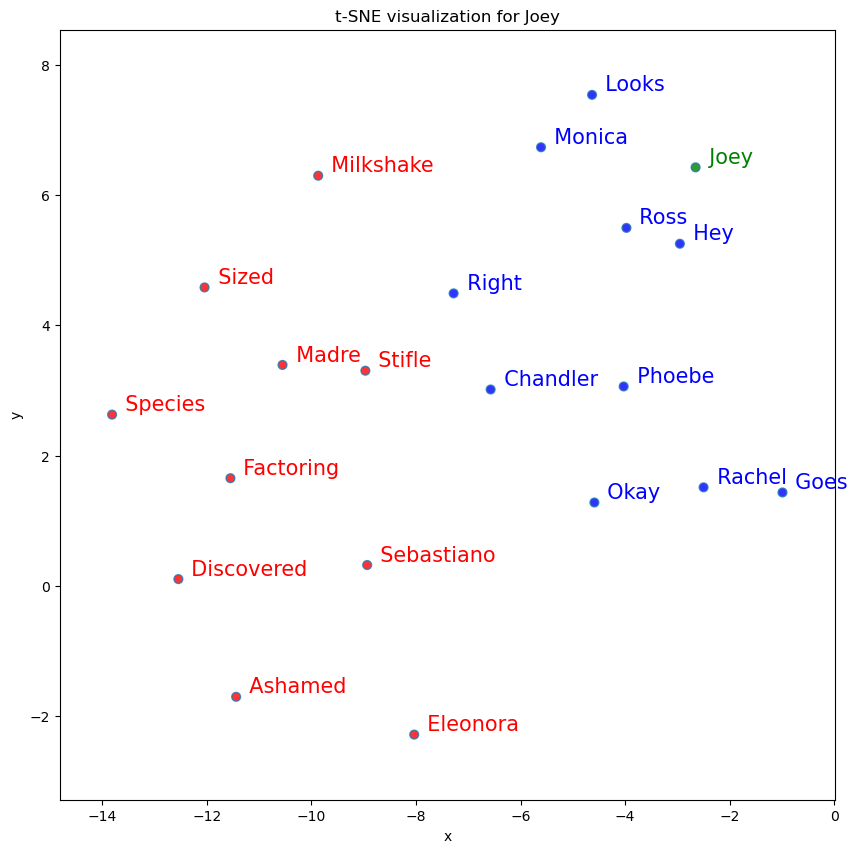

In [127]:
tsneplot(w2v, 'joey')

## **Task 2: Questions on the Conceptual Level (non-programming) (Grade (2 + 1 + 1 + 4) = 8)**

Please answer the following questions in the notebook cells using markdown. Be precise and short.

### Subtask 1: For gradient descent, what advantage has a decaying learning rate?

It helps to achieve faster convergence in the beginning and then to avoid overshooting the minimum. It ensures finer tuning when approaching the optimal solution.

### Subtask 2: Why is it easier to maximize the log likelihood instead of the "normal" likelihood?

Maximizing the log likelihood instead of the regular likelihood is computationally stable because it avoids very small numbers, it simplifies math by turning products into sums, and it can make optimization problems convex which eases the search for global maxima.

### Subtask 3: Name one advantage that fastText has over Word2Vec?

FastText can represent out-of-vocabulary words by averaging the embeddings of its subwords. Word2Vec can't handle words not seen during training.

### Subtask 4: Compute the partial derivate of softmax loss for word2vec with

---

respect to the center word vector.
$$ \frac{\partial J}{\partial v_c} =\frac{\partial}{\partial v_c}\left[ -log \left( \frac{exp(u^T_o v_c)}{\Sigma_{w \in Vocab} exp(u^T_o v_c)} \right)\right] $$
use $U$ to denote the matrix of all embeddings and $y$ for a one-hot vector with a 1 for the true outside word $o$, and $\hat{y}$ for the predicted distribution $P(w|c)$.

<<< your answer >>>

## **Task 3: Auto-Complete Feature (Grade (2 + 6 + 4) = 12)**

Let's get even more practical! In this problem set, you will build your own auto-completion system that you see every day while using search engines.

[google]: https://www.thedad.com/wp-content/uploads/2018/05/screen-shot-2018-05-12-at-2-01-56-pm.png "google auto complete"

![google]
By the end of this assignment, you will develop a simple prototype of such a system using n-gram language model. At the heart of the system is a language model that assigns the probability to a sequence of words. We take advantage of this probability calculation to predict the next word.

The problem set contains 3 main parts:

1. Load and preprocess data (tokenize and split into train and test)
2. Develop n-gram based language model by estimating the conditional probability of the next word.
3. Evaluate the model by computing the perplexity score.


### Subtask 1: Load and Preprocess Data
We use a subset of English tweets to train our model. Run the cell below to load the data and observe a few lines of it. Notice that tweets are saved in a text file, where the individual tweets are separated by `\n`

In [128]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser","ner"])


with open("./twitter.txt", "r") as f:
    data = f.read()
print("First 500 characters of the data:")
display(data[0:500])
print("-------")

First 500 characters of the data:


"How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to see you. Been way, way too long.\nWhen you meet someone special... you'll know. Your heart will beat more rapidly and you'll smile for no reason.\nthey've decided its more fun if I don't.\nSo Tired D; Played Lazer Tag & Ran A LOT D; Ughh Going To Sleep Like In 5 Minutes ;)\nWords from a complete stranger! Made my birthday even better :)\nFirst Cubs game ever! Wrigley field is gorgeous. This is perfect. Go Cubs Go!\ni no! i ge"

-------


Now we need to separate the tweets and split them into train and test set. Apply the following pre-processing steps:

1. Split data into sentences using "\n" as the delimiter and remove the leading and trailing spaces (drop empty sentences)
2. Tokenize the sentences into words using SpaCy and lowercase them. (notice that we do not remove stop words or punctuations.)
3. Divide the sentences into 80 percent training and 20 percent test set. No validation set is required. Although in a real-world application it is best to set aside part of the data for hyperparameter tuning.
4. To limit the vocabulary and remove potential spelling mistakes, make a vocabulary of the words that appear at least 2 times. The rest of the words will be replaced by the `<unk>` symbol. This is a crucial step since if your model encounters a word that it never saw during training, it won't have an input word that helps determining the next word for suggestion. We use the `<unk>` word for **out of Vocabulary (OOV)** words. Keep in mind that we built the vocabulary on the training data only.

In [129]:
import pprint 

sentences = data.split("\n")
sentences = [sent.strip() for sent in sentences if sent.strip() != ""]  #removes trailing whitespaces and empty strings

pprint.pprint(sentences[:3])

['How are you? Btw thanks for the RT. You gonna be in DC anytime soon? Love to '
 'see you. Been way, way too long.',
 "When you meet someone special... you'll know. Your heart will beat more "
 "rapidly and you'll smile for no reason.",
 "they've decided its more fun if I don't."]


In [130]:
tokenizer = nlp.tokenizer

tokenized_corpus = []  #list of list of the tokens in a sentence

for sent in sentences:
    tokens = [token.text for token in tokenizer(sent)]  #extract tokens from Doc object
    tokenized_corpus.append(tokens)

print(tokenized_corpus[:1])


[['How', 'are', 'you', '?', 'Btw', 'thanks', 'for', 'the', 'RT', '.', 'You', 'gon', 'na', 'be', 'in', 'DC', 'anytime', 'soon', '?', 'Love', 'to', 'see', 'you', '.', 'Been', 'way', ',', 'way', 'too', 'long', '.']]


In [131]:
from random import Random
Random(4).shuffle(tokenized_corpus)

split_index = int(0.8 * len(tokenized_corpus))

train = tokenized_corpus[:split_index]
test = tokenized_corpus[split_index:]

In [132]:
from collections import Counter
flatten_corpus = [token for sent in train for token in sent]

word_counts = Counter(flatten_corpus)
#print(word_counts)

### keep only the ones with frequency bigger than 2 ###
vocab = [word for word, count in word_counts.items() if count > 2]  #in the task description above is written "at least 2" which would be "> 1", but here it's "bigger than 2"
#vocab = [word for word, count in word_counts.items() if count > 1]
print(len(vocab)) ### should be 14861 ###

train_replaced = []
test_replaced = []
for sentence in train:
    ### adjust the sentence to contain the word in the vocabulary and <unk> for the rest ####
    replaced_sent = ["<unk>" if word not in vocab else word for word in sentence]
    train_replaced.append(replaced_sent)

for sentence in test:
    replaced_sent = ["<unk>" if word not in vocab else word for word in sentence]
    test_replaced.append(replaced_sent)

12353


In [133]:
print(test_replaced)

[['This', 'week', 'has', 'been', 'so', 'beautifully', 'busy', '...', 'busy', 'busy', '<unk>', 'we', "'ve", 'been', '!'], ['#', 'goodnight', 'Twitter', '!', '❤', '💤'], ['guess', 'how', 'old', 'loll'], ['Its', 'always', 'an', 'interesting', 'day', 'when', 'we', 'are', '<unk>', 'to', 'space', 'aliens', 'and', '<unk>', '!', 'lol'], ['<unk>', 'mercy', '!', '<unk>', 'best', 'school', 'ever', '!', 'I', 'went', 'there', 'for', 'a', 'tour', 'and', 'loved', 'it', '<333'], ['already', 'following', 'u'], ['Wow', '!', '!', 'just', 'said', '"', 'He', 'would', 'take', 'Rogers', 'over', 'any', 'other', 'QB', 'in', 'the', '#', 'NFL', ',', 'even', 'Peyton', ',', 'Brees', ',', 'and', 'Brady', '.'], ['What', 's', 'on', 'my', 'mind', 'is', 'me', '<unk>', 'about', 'them', '<unk>', 'in', 'life', 'and', 'being', 'able', 'to', 'make', 'it', 'on', 'their', 'own', '...'], ['Okay', ',', 'who', '<unk>', 'a', 'red', '-', 'hot', 'poker', 'in', 'my', 'left', 'hip', 'while', 'I', 'was', 'asleep', '?'], ['Happy', 'Than

### Subtask 2: N-gram Based Language Model:
In this section, you will develop an n-grams language model [**1. Large Language Models (LLMs), slide 1-24**]. We assume that the probability of the next word depends only on the previous n-gram or previous n words. We compute this probability by counting the occurrences in the corpus.
The conditional probability for the word at position 't' in the sentence, given that the words preceding it are $w_{t-1}, w_{t-2} \cdots w_{t-n}$ can be estimated as follows:

$$ \hat{P}(w_t | w_{t-1}\dots w_{t-n}) = \frac{C(w_{t-1}\dots w_{t-n}, w_t)}{C(w_{t-1}\dots w_{t-n})}  $$

The numerator is the number of times word '$w_t$' appears after the n-gram, and the denominator is the number of times the n-gram occurs in the corpus, where $C(\cdots)$ is a count function. Later, we add k-smoothing to avoid errors when any counts are zero.

To tackle the problem of probability estimation we divide the problem into 3 parts. In the following you will:
1. Implement a function that computes the counts of n-grams for an arbitrary number n.
2. Estimate the probability of a word given the prior n-words using the n-gram counts.
3. Calculate probabilities for all possible words.
The steps are detailed below.

Let's start by implementing a function that computes the counts of n-grams for an arbitrary number n.
- Prepend necessary starting markers `<s>` to indicate the beginning of the sentence. In the case of a bi-gram model, you need to prepend two start tokens `<s><s>` to be able to predict the first word. "hello world"-> "`<s><s>`hello world".
- Append an end token `<e>` so that the model can predict when to finish a sentence.
- Create a dictionary to store all the n_gram counts.

In [134]:
from collections import defaultdict

def n_grams_counts(corpus, n):
    """
    Count all n-grams in the corpus given the parameter n

    data: List of lists of words (your tokenized corpus)
    n: n in the n-gram

    Returns: A dictionary that maps a tuple of n words to its frequency
    """
    start_token='<s>'
    end_token = '<e>'
    n_grams = defaultdict(int)
    for sentence in corpus:
        ### add start and end token ###
        sentence = n * [start_token] + sentence + [end_token]

        # convert list to tuple so it can be used a the key in the dictionary
        sentence = tuple(sentence)

        ###iterate over the n-grams in the sentence, you can use the range() function, and increment the counts in the
        ## n_grams dictionary, where the key is the n_gram and the value is count
        for i in range(len(sentence) - n + 1):
            n_gram = sentence[i:i+n]   #iterate according to n-grams (steps of n=1 or n=2)
            n_grams[n_gram] += 1

    return n_grams

In [135]:
from itertools import islice

n_gram_dict = n_grams_counts(train_replaced, 2)

for n_gram, count in islice(n_gram_dict.items(), 10):
    print(f'{n_gram}: {count}')

('<s>', '<s>'): 38368
('<s>', 'Be'): 34
('Be', 'safe'): 6
('safe', '!'): 5
('!', '!'): 4992
('!', '<e>'): 7655
('<s>', 'Working'): 36
('Working', 'today'): 1
('today', 'in'): 20
('in', 'Madison'): 5


The next step is to estimate the probability of a word given the prior n words using the n-gram counts, based on the formula given at the beginning of this task. To deal with the problem of zero division we add k-smoothing. K-smoothing adds a positive constant $k$ to each numerator and $k \times |vocabulary size|$ in the denominator. Below we will define a function that takes in a dictionary `n_gram_cnt`, where the key is the n-gram, and the value is the count of that n-gram, plus a dictionary for `plus_current_gram_cnt`, which you'll use to find the count for the previous n-gram plus the current word. Notice that these dictionaries are computed using the previous function `n_grams_counts`.


In [136]:
def probability(word, prev_n_gram,
                         n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Estimate the probabilities of the next word using the n-gram counts with k-smoothing
    word: next word
    prev_n_gram: previous n gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of words in the vocabulary

    Returns: A probability
    """
    k = 1.0
    prev_n_gram = tuple(prev_n_gram)

    prev_n_gram_cnt = n_gram_cnts.get(prev_n_gram, 0) # get the previous n-gram count from the dictionary, if not present: 0

    denominator = prev_n_gram_cnt + (k * vocab_size) # denominator with the previous n-gram count and k-smoothing

    plus_current_gram =  prev_n_gram + (word,) # add the current word to the n-gram

    plus_current_gram_cnt = plus_current_gram_cnts.get(plus_current_gram, 0) # get the current n-gram count using the dictionary

    numerator = plus_current_gram_cnt + k #calculate the numerator with k-smoothing

    prob = numerator / denominator

    return prob

Let's use the functions we have defined to calculate probabilities for all possible words.


In [137]:
def probabilities(prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab):
    """
    Estimate the probabilities for all the words in the vocabulary given the previous n-gram
    prev_n_gram: previous n-gram
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cntsplus_current_gram_cnt: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words

    Returns: A dictionary mapping from next words to the probability.
    """
    prev_n_gram = tuple(prev_n_gram)

    vocab = set(vocab + ["<e>", "<unk>"]) # add <e> <unk> to the vocabulary
    vocabulary_size = len(vocab)

    probabilities = {}
    for word in vocab:
        ### compute the probability
        prob = probability(word, prev_n_gram, n_gram_cnts, plus_current_gram_cnts, vocabulary_size)
        probabilities[word] = prob

    return probabilities

In [138]:
# Predict the probability of all possible words after the unigram "the"
sentences = [['the', 'moon', 'and', 'stars', 'are','shining','bright'],
             ['the', 'moon', 'is', 'shinnig','tonight'],
             ['mars','and' ,'moon', 'are', 'plants'],
             ['the' ,'moon', 'is','a', 'plant']]
unique_words = list(set(sentences[0] + sentences[1] + sentences[2]+ sentences[3]))
unigram_counts = n_grams_counts(sentences, 1)
bigram_counts = n_grams_counts(sentences, 2)
print("The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.")
probabilities(["the"], unigram_counts, bigram_counts, unique_words)

The word 'moon' should have the highest probability, if it is not the case, re-visit your previous functions.


{'bright': 0.05263157894736842,
 'is': 0.05263157894736842,
 'shinnig': 0.05263157894736842,
 'a': 0.05263157894736842,
 'plants': 0.05263157894736842,
 'are': 0.05263157894736842,
 'shining': 0.05263157894736842,
 'the': 0.05263157894736842,
 '<e>': 0.05263157894736842,
 'stars': 0.05263157894736842,
 'mars': 0.05263157894736842,
 'and': 0.05263157894736842,
 '<unk>': 0.05263157894736842,
 'moon': 0.21052631578947367,
 'tonight': 0.05263157894736842,
 'plant': 0.05263157894736842}

### Subtask 3: Evaluation

In this part, we use the perplexity score to evaluate your model on the test set. The perplexity score of the test set on an n-gram model is defined as follows:

$$ PP(W) =\sqrt[N]{ \prod_{t=n}^{N-1} \frac{1}{P(w_t | w_{t-n} \cdots w_{t-1})} } $$
- where $N$ is the length of the sentence. ($N-1$ is used because in the code we start from the index 0).
- $n$ is the number of words in the n-gram.
- $W$ is the n-gram

Notice that we have already computed this probability.

The higher the probabilities are, the lower the perplexity will be.

In [139]:
def perplexity(sentence, n_gram_cnts, plus_current_gram_cnts, vocab_size, k=1.0):
    """
    Calculate perplexity for a list of sentences
    sentence: List of strings
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab_size: number of unique words in the vocabulary
    k: positive smoothing constant

    Returns: Perplexity score for a single sentence
    """

    n = len(next(iter(n_gram_cnts))) # get the number 'n' in  n-gram  from n_gram_cnts

    sentence =  n * ["<s>"] + sentence + ["<e>"] # prepend <s> and append <e>
    sentence = tuple(sentence)
    N = len(sentence) # length of sentence


    product_pi = 1.0

    ### Compute the product of probabilities ###

    for t in range(n, N):
        n_gram = tuple(sentence[t - n:t]) # get the n-gram before the predicted word (n-gram before t ) -> starting at n: if n=2 then sentence[2-2:2]
        word = sentence[t] # get the word to be predicted (position t)
        prob = probability(word, n_gram, n_gram_cnts, plus_current_gram_cnts, vocab_size) # your code instead of ....
        product_pi *= 1 / prob # Update the product of the probabilities

    perplexity = product_pi**(1/float(N)) # Take the Nth root of the product
    
    return perplexity

Use `perplexity` function to find the perplexity of a bi-gram model on the first training sample and on the first test sample (first element of the set).

In [140]:
bigram_counts = n_grams_counts(train_replaced, 2)
trigram_counts = n_grams_counts(train_replaced, 3)

perplexity_train = perplexity(train_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for first train sample: {perplexity_train:.4f}")

perplexity_test = perplexity(test_replaced[0],bigram_counts, trigram_counts,len(vocab))
print(f"Perplexity for test sample: {perplexity_test:.4f}") # the perplexity for the train sample should be much lower

Perplexity for first train sample: 138.4454
Perplexity for test sample: 2430.1345


Finally, let's use the model we created to generate an auto-complete system that makes suggestions.

In [141]:
def suggest_a_word(up_to_here, n_gram_cnts, plus_current_gram_cnts, vocab, start_with=None):
    """
    Get suggestion for the next word
    up_to_here: the sentence so far, must have length > n
    n_gram_cnts: dictionary of counts of n-grams
    plus_current_gram_cnts: dictionary of counts of (n+1)-grams -> current word+ n-gram = (n+1)-gram
    vocab: List of words
    start_with: If not None, specifies the first few letters of the next word

    Returns: (most likely next word,  probability)
    """
    n = len(list(n_gram_cnts.keys())[0]) # get the number 'n' in  n-gram  from n_gram_cnts
    previous_n_gram = previous_tokens[-n:] # get the last 'n' words as the previous n-gram from the input sentence


    probabs = probabilities(previous_n_gram, n_gram_cnts, plus_current_gram_cnts, vocab) # Estimate the probabilities for each word in the vocabulary

    ### sort the probability for higher to lower and return the highest probability word,probability tuple
    #if start_with is specified then return the highest probability word that starts with that specific character
    if start_with:
        probabs = {word: prob for word, prob in probabs.items() if word.startswith(start_with)} # select only words starting with given letter

    best_next_word = max(probabs, key=probabs.get)
    best_prob = probabs[best_next_word]

    return best_next_word, round(best_prob, 6)


Test your model based on the bi-gram model created on the training corpus.

In [142]:
previous_tokens=['i','like']
start_with='b'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('boys', 0.000162)

In [143]:
previous_tokens=['i','like','to']
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('see', 0.000723)

In [144]:
previous_tokens=["hello", "my", "name", "is"]
start_with=None
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('<unk>', 0.000404)

In [145]:
previous_tokens=["hello", "my", "name", "is"]
start_with='a'
suggestion = suggest_a_word(previous_tokens, bigram_counts,trigram_counts, list(vocab),start_with=start_with)
suggestion

('approved', 8.1e-05)

## **Task 4: Understanding GloVe (Grade (2 + 4.25 + 4 + 1.75) = 12)**

In this part, you will implement the [GloVe](https://nlp.stanford.edu/projects/glove/) model and train your own word vectors with gradient
descent and numpy. GloVe stands for Global Vectors for word representation, which was developed by researchers at Stanford University to generate word embeddings from corpus statistics.
The statistics of the corpus are represented by a co-occurrence matrix, indicating how often a particular word pair occurs together.
GloVe is based on ratios of probabilities from this co-occurrence matrix, combining the intuitions of count-based models while also being similar to neural models like word2vec.
From this matrix, one can compute the co-occurrence probabilities. We motivate this with an example:

$P_{ik} = P(i,j)$ -> co-occurrence probability or joint probability of words $i$ and $k$

$P_{jk}$ ->co-occurrence probability of words $j$ and $k$

$\frac{P_{ik}}{P_{jk}}$-> corelation between $i$ and $j$ with the prob word $k$

This ratio gives us some insight into the co-relation of the probe word $k$ with the words $i$ and $j$.
An example is shown below for different prob words $k$, where $i$ and $j$ are `ice` and `steam`, respectively.


![glove](https://nlp.stanford.edu/projects/glove/images/table.png)


Image taken from Stanford NLP.

Compared to the raw probabilities, the ratio of probabilities is better able to distinguish relevant words from irrelevant words. Consider the raw probabilities (the first two rows), the values are close to one another and not indicative of the relationships. However, the ratios have more distinct values.

This ratio can be small, large, or equal to 1 depending on the prob word and their co-relation. In the example above, the ratio between ice and steam for `k=solid` is large and for `k=gas` is small, indicating that `solid` is related to ice but `gas` is irrelevant. On the other hand, `water` is not a discriminating element between them, and therefore the ratio is close to one. The same applies to an irrelevant word like `fashion`.

The GloVe model is built on the idea that the "ratio of conditional probabilities represents the word meanings" and a neural model is trained to estimate this conditional probability.

$F(w_i,w_j,\tilde{w_k})=\frac{P_ik}{P_jk}$ -> the right-hand side is computed from the corpus statistics, $w$ is the word vector and $\tilde{w_k}$ is the context vector

The GloVe model embeds the words in a vector space and claims that the difference between them (distinguishing factor) is hidden in the ratio of probabilities. In vector space, the best way to encode this is by vector differences.

$F((w_i-w_j),\tilde{w_k})=\frac{P_ik}{P_jk}$

At this point, the left-hand side is a vector and the right-hand side is a scalar showing the similarity of i and j with the context word k.
For both sides to match and to encode the similarity in the vector space, the left-hand side becomes a dot product.

$F((w_i-w_j)^{T}.\tilde{w_k})=\frac{P_ik}{P_jk}=\frac{F(w_i.\tilde{w_k})}{F(w_j.\tilde{w_k})} $

$F(w_i.\tilde{w_k})=\frac{X_{ik}}{X_{i}}$ -> where $X$ is drived from the co-occurrences matrix

To satisfy a symmetrical relationship (a.k.a. relation(a, b) = relation(b, a)), $F$ is chosen to be an exponential function, $F(x)=exp(x)$. As a result:

$w_i.\tilde{w_k} = log(P_{ik} ) = log(X_{ik} ) − log(X_{i})$

$log(X_{i})$ is independent of $k$ and can be absored into a bias term.

$w_i.\tilde{w_k} = log(P_{ik} ) + b_i +\tilde{b_k} = log(X_{ik} )$

After some weighting and alterations the final cost function, based on the weighted least squares regression model is as follows:

$J= \Sigma^{V}_{i,j=1} f(X_{ij})(w_i.w_j+ b_i +b_j)-log(X_{ik})$

For a detailed overview refer to the original paper: https://nlp.stanford.edu/pubs/glove.pdf
You need to read and understand the GloVe model to solve this exercise.


### Subtask 1: Cost function

Read the paper and describe the following, in your own words:

 1. The intuition behind the weighting schema in the cost function.

 2. How does the objective function of GloVe relate to the objective function of the (word2vec) skip-gram model?

1. The intuition is to achieve 3 main effects:

    1. **Being 0 when co-occurrence count is 0:** If two words never co-occur, their relationship is undefined in the context of the corpus, and it's not meaningful to assign a weight to this non-existent relationship. 

    2. **Being non-decreasing $\Rightarrow$ not assigning a higher weight to rarely co-occurring words:** Rare co-occurrences might be due to random chance or noise in the data, and should not disproportionately affect the learned word vectors. By ensuring the function is non-decreasing, one can ensure that as the co-occurrence count increases, the weight does not decrease.

    3. **Not assigning disproportionately high weight to frequently co-occurring words:** Very frequent words tend to co-occur with many other words simply due to their high frequency. Capping the weight for high co-occurrence counts prevents less meaningful co-occurrences from dominating the learning process.


2. Both are based on the occurrence statistics of a corpus. The skip-gram model attempts to maximize the log probability of a word appearing in the context of another word, but it introduces approximations to allow for efficient training, and it trains in an online, stochastic fashion. In contrast, GloVe captures the global corpus statistics directly by training on the nonzero elements in a word-word co-occurrence matrix, rather than on individual context windows in a large corpus.

### Subtask 2: Build Co-occurence matrix


We use the same dataset as the first task and use the `quotes` as the corpus to build the co-occurrences matrix. Similar to the first task we use the `phrases` to transform our input and extract the vocabulary.

In [146]:
import numpy as np
from scipy import sparse
from math import log
from itertools import chain
from collections import Counter
from tqdm import tqdm

Complete the function to create dictionaries used for mapping ids to words and words to ids, and a dictionary that counts the number of occurrences of each word. The first two dictionaries are used to map indices in vector space to words and back, and the third dictionary contains the counts of the corpus statistics.

In [147]:
print(new_lines[0])

vocab = [word for line in new_lines for word in line]
vocab_counts = dict(Counter(vocab))

word_to_id = {word: id for id, word in enumerate(sorted(set(vocab)))} # mapping words to ids
id_to_word = {id: word for word, id in word_to_id.items()} # mapping ids to words

print(word_to_id)
print(id_to_word)

['tell', 'guy', 'work']
{'00': 0, '000': 1, '007': 2, '02': 3, '038': 4, '03815': 5, '0w33815': 6, '10': 7, '100': 8, '101': 9, '1066': 10, '10th': 11, '11': 12, '110': 13, '1100': 14, '112': 15, '12': 16, '1200': 17, '127': 18, '128': 19, '129': 20, '13': 21, '130': 22, '131': 23, '14': 24, '1400': 25, '1450': 26, '147': 27, '14th': 28, '15': 29, '150': 30, '152': 31, '153': 32, '15s': 33, '15th': 34, '16': 35, '160': 36, '16th': 37, '17': 38, '170': 39, '1700': 40, '1776': 41, '17th': 42, '18': 43, '1800': 44, '1890': 45, '18th': 46, '19': 47, '1920s': 48, '1922': 49, '1939': 50, '1965': 51, '1968': 52, '1979': 53, '1981': 54, '1982': 55, '1985': 56, '1986': 57, '1987': 58, '1989': 59, '1990': 60, '1992': 61, '1995': 62, '1996': 63, '1997': 64, '1998': 65, '1999': 66, '1a': 67, '20': 68, '200': 69, '2000': 70, '2002': 71, '2003': 72, '2020': 73, '2030': 74, '2032': 75, '206': 76, '208': 77, '20th': 78, '21': 79, '210': 80, '2100': 81, '2101': 82, '217': 83, '21st': 84, '22': 85, '226

In [148]:
def create_vocab(corpus):
  """
  Build a vocabulary containing the frequencies
  corpus: the list of tokenized lines form the corpus

  Returns  dictionaries `word` -> (index or unique identified), frequency)`
  and `word` -> (index or unique identified)
  and index or unique identified -> `word`
  and length of the vocab
  """
  ### you code goes here###
  vocab = [word for line in corpus for word in line]
  vocab_counts = dict(Counter(vocab)) 
  
  word_to_id = {word: id for id, word in enumerate(sorted(set(vocab)))} # mapping words to ids
  id_to_word = {id: word for word, id in word_to_id.items()} # mapping ids to words
  word_count_dict = {word_to_id[word]: count for word, count in vocab_counts.items()} # word id to the number of time it appears

  return word_count_dict,id_to_word, word_to_id, len(word_count_dict)

In [149]:
word_count_dict, id_to_word, word_to_id, vocab_size=create_vocab(new_lines)

If you have done the exercise correctly, you have `15333` tokens in the vocabulary, and the number of occurrences for `joey` is `1951` and for `central_perk` is `36`

In [150]:
print("number of occurrences for joey:",word_count_dict[word_to_id['joey']])
print("number of occurrences for central perk:",word_count_dict[word_to_id['central_perk']])
print("vocab size is:",vocab_size)

number of occurrences for joey: 2234
number of occurrences for central perk: 36
vocab size is: 15944


In [151]:
def calculate_weight(cooccurrences, context_word_ids, center_word_id, side):
    """
    Calculate the weight in the co-occurrence matrix based on the distance of a word
    to the center word
    sentence = [I, went, to , the, bank]
    Let center word be "to" and window size = 2
    left_context = [I,went]
    right_context = [the,bank]

    Weights:
    1/distance -> `went` and `the` have weight of 1 and `I` and `bank` have weight of 1/2
    """
    if side != "right_context":                 
        context_word_ids.reverse()

    ## adjust the weight of the matrix to 1/distance between the center word and context word, where center word will act as the row and the context word is the column##
    for distance, word_id in enumerate(context_word_ids, start=1):
        weight = 1.0 / distance
        cooccurrences[center_word_id, word_id] += weight
        
    return cooccurrences

The weight of first to second element on the example matrix should be `1.0`.

In [152]:
cooccurrences = sparse.lil_matrix((10, 10), dtype=np.float64)

calculate_weight(cooccurrences, [1,3,5], 0, side="right_context")
print("weight of id=0 to id=1 :", cooccurrences[0,1])

cooccurrences.toarray()

weight of id=0 to id=1 : 1.0


array([[0.        , 1.        , 0.        , 0.5       , 0.        ,
        0.33333333, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

We build co-occurrence as a sparse matrix to speed up the computation. The original matrix is a square matrix in the size of the vocabulary. However, many words do not co-occur with one another and we do not need to store those elements.

In [153]:
def build_cooccur(corpus, window_size=3, min_count=5):
    """
    Create a coocurrance matrix given a corpus
    corpus: the list of tokenized lines form the corpus
    window_size: how many words to right and left to consider

    Returns the co-oocurrance sparse matrix
    """
    vocab, id_to_word,word_to_id, vocab_size = create_vocab(corpus)

    #sparse lil_matrix is optimized to operate on matrix which mostly has zeros.
    cooccurrences = sparse.lil_matrix((vocab_size, vocab_size), dtype=np.float64)

    for i, line in enumerate(corpus):

        #Get the ID of words from vocab dictionary
        word_ids = [word_to_id[word] for word in line]

        for center_idx, center_word_id in enumerate(word_ids):  #changed variable i to center_idx to prevent bugs since i is already used in outside loop

            left_context_word_ids  = word_ids[max(0, center_idx - window_size) : center_idx] #left side context: use max(0, ...) to prevent negative indices when center word is near beginning of line

            right_context_word_ids = word_ids[center_idx + 1 : min(len(word_ids), center_idx + window_size + 1)] #right side context: use min(...) to prevent index beyond length of word_ids when center word near end of line

            ###update the matrix based on the distance weights on both sides###
            cooccurrences = calculate_weight(cooccurrences,left_context_word_ids, center_word_id, side="left_context")
            cooccurrences = calculate_weight(cooccurrences, right_context_word_ids, center_word_id, side="right_context")

    # go into the LiL-matrix to quickly iterate through all nonzero cells and filter out the ones with minimum count
    cooccurrences_tuples = []
    for i, (row, data) in enumerate(zip(cooccurrences.rows,cooccurrences.data)):
        ## check if the min_count condition is statisfied and then add the elements as the tuple of (i,j,weight)###
        if word_count_dict[i] < min_count:  # The frequency of the center word should not be less than min_count
            continue
        for j, weight in zip(row, data):
            if j >= min_count:  # The frequency of the context word should be more or equal to min_count
                cooccurrences_tuples.append((i, j, weight))
                
    return cooccurrences_tuples


Build a matrix with a window_size of 3 words, and the minimum number of times a word has to occur to be part of the matrix is 10.

In [154]:
matrix=build_cooccur(new_lines, window_size=3, min_count=10)
matrix[103]

(1, 3505, 0.3333333333333333)

### Subtask 3: Modelling and Training


We initialize the weights for the context and center words and learn the vectors through backprop, using the GloVe cost function.
Make sure you use the correct weighting schema.

In [155]:
# Random normal weights intialization
np.random.seed(77) # we set a seed to have similar results

def init_weights(vocab_size, hidden):
     #Each word has a center word vector and a context vector.
     W_center = np.random.randn(vocab_size, hidden) * 0.1 # initilize the correct size vector (multiply by 0.1 to keep the weights small)
     b_center = np.zeros(vocab_size) # initilize the correct size vector
     W_context = np.random.randn(vocab_size, hidden) * 0.1 # initilize the correct size vector
     b_context = np.zeros(vocab_size) # initilize the correct size vector
     return W_center, b_center, W_context, b_context

keep track of `W_center[0,1]` as it should change based on backprop in the next cells.

In [156]:
W_center, b_center, W_context, b_context = init_weights(100, 32)
print("check the shapes to make sure the matrices have correct sizes:")
print(W_center.shape)
print(b_center.shape)
print(W_context.shape)
print(b_context.shape)
print("Look at the value of this element and how it changes with back prob:")
print(W_center[0,1])

check the shapes to make sure the matrices have correct sizes:
(100, 32)
(100,)
(100, 32)
(100,)
Look at the value of this element and how it changes with back prob:
0.06615314728168009


Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

In [157]:
# Back Propagation
def back_prop(W_center, b_center, W_context, b_context, matrix, x_max, vocab_size, learning_rate, alpha=2):
    """
    W_center, b_center: weight and bias of the center word
    W_context, b_context: weight and bias of the context word
    vocab_size: vocabulary size
    x_max: define our weighting function when computing the cost for two word pairs; see the GloVe paper for more
    details.
    matrix: coocurrance matrix
    alpha: the power of x_max function (controls how the weighting function behaves with respect to the co-occurrence count Xij)
    learning_rate: learning rate for gradient descent
    """

    global_cost = 0

    for i, j, cooccurrence in matrix:
            
            weight = ((cooccurrence / x_max) ** alpha if (cooccurrence < x_max) else 1)

            # Compute inner component of cost function  J' = w_i^Tw_j + b_i + b_j - log(X_{ij})
            cost_inner = np.dot(W_center[i], W_context[j]) + b_center[i] + b_context[j] - np.log(cooccurrence)

            ##Compute cost J = f(X_{ij}) (J')^2##
            cost = weight * (cost_inner**2)
            global_cost += cost  # Update total cost

            ##Compute gradients for word vectors##
            grad_w_center = weight * cost_inner * W_context[j]
            grad_w_context = weight * cost_inner * W_center[i]

            ##Compute gradients for bias terms##
            grad_b_center = weight * cost_inner 
            grad_b_context = weight * cost_inner 

            ##update the weights##
            W_center[i] -= learning_rate * grad_w_center
            W_context[j] -= learning_rate * grad_w_context
            b_center[i] -= learning_rate * grad_b_center
            b_context[j] -= learning_rate * grad_b_context

    return W_center, b_center, W_context, b_context, global_cost

Based on the random seed, the value of `W_center[0,1]` should have changed due to backpropagation.


In [158]:
test_matrix = [(0,1,1),(0,2,0.4),(0,3,0.9),(0,4,0.4)]
W_center, b_center, W_context, b_context, global_cost = back_prop(W_center, b_center, W_context, b_context, test_matrix, x_max=10, vocab_size=100, learning_rate=0.01)
print("cost:",global_cost)
print("changed value:")
print(W_center[0,1])

cost: 0.0026227977446373063
changed value:
0.06615192930563898



Write a training script for the GloVe model that goes over the entire co-occurrence matrix given a number of epochs.

In [159]:
def train_GloVe(matrix, vocab_size, epochs=10, learning_rate=0.0001, x_max=10, hidden_dim=100, alpha=2):
    """
    Train the glove model based the co-ocurrance matrix for a number of epochs
    matrix: co-occcurance matrix
    vocab_size: number of words in vocab
    epochs: number of passes through the data
    learning_rate: learning rate for back prop
    x_max: parameter of the weighting function
    hidden_dim: dimension of the vectors
    """
    W_center, b_center, W_context, b_context = init_weights(vocab_size, hidden_dim)

    for i in tqdm(range(epochs)):
        ### perform backprop###
        W_center, b_center, W_context, b_context, global_cost = back_prop(
            W_center, b_center, W_context, b_context, matrix=matrix, x_max=x_max, vocab_size=vocab_size, 
            learning_rate=learning_rate, alpha=alpha)

        print(global_cost)

    return W_center, W_context

Train the model with hidden dimension of `100` and learning rate of `0.001` for a `100` epochs.

In [ ]:
W_center, W_context = train_GloVe(matrix, vocab_size, hidden_dim=100, learning_rate=0.001, epochs=100, x_max=10)

  1%|▍                                          | 1/100 [00:02<04:05,  2.48s/it]

64776.972143595136


  2%|▊                                          | 2/100 [00:04<04:02,  2.47s/it]

45134.441409494604


  3%|█▎                                         | 3/100 [00:07<04:00,  2.47s/it]

33624.338943068164


  4%|█▋                                         | 4/100 [00:09<03:57,  2.47s/it]

26626.295261024396


  5%|██▏                                        | 5/100 [00:12<03:54,  2.47s/it]

22223.835531071105


  6%|██▌                                        | 6/100 [00:14<03:52,  2.47s/it]

19363.073441122076


  7%|███                                        | 7/100 [00:17<03:50,  2.48s/it]

17444.445421845096


  8%|███▍                                       | 8/100 [00:19<03:47,  2.47s/it]

16116.554501030363


  9%|███▊                                       | 9/100 [00:22<03:44,  2.47s/it]

15168.023039250857


 10%|████▏                                     | 10/100 [00:24<03:42,  2.47s/it]

14468.736641151967


 11%|████▌                                     | 11/100 [00:27<03:39,  2.47s/it]

13936.913480614608


 12%|█████                                     | 12/100 [00:29<03:37,  2.47s/it]

13520.141707622413


 13%|█████▍                                    | 13/100 [00:32<03:34,  2.47s/it]

13184.201768992385


 14%|█████▉                                    | 14/100 [00:34<03:31,  2.46s/it]

12906.342064862769


 15%|██████▎                                   | 15/100 [00:37<03:29,  2.47s/it]

12671.160031503452


 16%|██████▋                                   | 16/100 [00:39<03:26,  2.46s/it]

12468.037563894446


 17%|███████▏                                  | 17/100 [00:41<03:24,  2.46s/it]

12289.519816533355


 18%|███████▌                                  | 18/100 [00:44<03:22,  2.46s/it]

12130.275514300338


 19%|███████▉                                  | 19/100 [00:46<03:20,  2.47s/it]

11986.420869523014


 20%|████████▍                                 | 20/100 [00:49<03:19,  2.49s/it]

11855.073930595783


 21%|████████▊                                 | 21/100 [00:51<03:16,  2.48s/it]

11734.056855669494


 22%|█████████▏                                | 22/100 [00:54<03:13,  2.48s/it]

11621.694340489625


 23%|█████████▋                                | 23/100 [00:56<03:09,  2.47s/it]

11516.675318805343


 24%|██████████                                | 24/100 [00:59<03:07,  2.47s/it]

11417.956805117832


 25%|██████████▌                               | 25/100 [01:01<03:04,  2.46s/it]

11324.69614520293


 26%|██████████▉                               | 26/100 [01:04<03:01,  2.46s/it]

11236.202646284191


 27%|███████████▎                              | 27/100 [01:06<03:00,  2.48s/it]

11151.902586379767


 28%|███████████▊                              | 28/100 [01:09<02:58,  2.48s/it]

11071.3135705878


 29%|████████████▏                             | 29/100 [01:11<02:56,  2.48s/it]

10994.025495087883


 30%|████████████▌                             | 30/100 [01:14<02:57,  2.54s/it]

10919.686237700349


 31%|█████████████                             | 31/100 [01:16<02:55,  2.54s/it]

10847.99076915969


 32%|█████████████▍                            | 32/100 [01:19<02:51,  2.53s/it]

10778.67276882529


 33%|█████████████▊                            | 33/100 [01:21<02:48,  2.51s/it]

10711.498095039904


 34%|██████████████▎                           | 34/100 [01:24<02:45,  2.50s/it]

10646.259644387264


 35%|██████████████▋                           | 35/100 [01:26<02:42,  2.50s/it]

10582.7732625307


 36%|███████████████                           | 36/100 [01:29<02:39,  2.49s/it]

10520.874459723073


 37%|███████████████▌                          | 37/100 [01:31<02:36,  2.49s/it]

10460.415748418412


 38%|███████████████▉                          | 38/100 [01:34<02:33,  2.48s/it]

10401.26446657374


 39%|████████████████▍                         | 39/100 [01:36<02:31,  2.48s/it]

10343.300983688176


 40%|████████████████▊                         | 40/100 [01:39<02:28,  2.48s/it]

10286.417211081154


 41%|█████████████████▏                        | 41/100 [01:41<02:26,  2.48s/it]

10230.51535597878


 42%|█████████████████▋                        | 42/100 [01:44<02:23,  2.48s/it]

10175.506872387665


 43%|██████████████████                        | 43/100 [01:46<02:21,  2.48s/it]

10121.31157182343


 44%|██████████████████▍                       | 44/100 [01:49<02:18,  2.48s/it]

10067.856864615283


 45%|██████████████████▉                       | 45/100 [01:51<02:16,  2.48s/it]

10015.077108306865


 46%|███████████████████▎                      | 46/100 [01:54<02:13,  2.48s/it]

9962.91304418505


 47%|███████████████████▋                      | 47/100 [01:56<02:11,  2.47s/it]

9911.311306442949


 48%|████████████████████▏                     | 48/100 [01:59<02:08,  2.48s/it]

9860.223991234645


 49%|████████████████████▌                     | 49/100 [02:01<02:06,  2.47s/it]

9809.608275025961


 50%|█████████████████████                     | 50/100 [02:04<02:03,  2.48s/it]

9759.426073405713


 51%|█████████████████████▍                    | 51/100 [02:06<02:01,  2.48s/it]

9709.643732910483


 52%|█████████████████████▊                    | 52/100 [02:08<01:58,  2.48s/it]

9660.231749590364


 53%|██████████████████████▎                   | 53/100 [02:11<01:56,  2.48s/it]

9611.164509005483


 54%|██████████████████████▋                   | 54/100 [02:13<01:53,  2.48s/it]

9562.420043159364


 55%|███████████████████████                   | 55/100 [02:16<01:51,  2.48s/it]

9513.979800602916


 56%|███████████████████████▌                  | 56/100 [02:18<01:48,  2.48s/it]

9465.82842654044


 57%|███████████████████████▉                  | 57/100 [02:21<01:46,  2.48s/it]

9417.953550353393


 58%|████████████████████████▎                 | 58/100 [02:23<01:44,  2.48s/it]

9370.345578430499


 59%|████████████████████████▊                 | 59/100 [02:26<01:41,  2.48s/it]

9322.9974906819


 60%|█████████████████████████▏                | 60/100 [02:28<01:39,  2.48s/it]

9275.904639507926


 61%|█████████████████████████▌                | 61/100 [02:31<01:36,  2.48s/it]

9229.064550406432


 62%|██████████████████████████                | 62/100 [02:33<01:34,  2.49s/it]

9182.476723740594


 63%|██████████████████████████▍               | 63/100 [02:36<01:32,  2.49s/it]

9136.142437526765


 64%|██████████████████████████▉               | 64/100 [02:38<01:29,  2.49s/it]

9090.064551402409


 65%|███████████████████████████▎              | 65/100 [02:41<01:26,  2.48s/it]

9044.24731216981


 66%|███████████████████████████▋              | 66/100 [02:43<01:24,  2.48s/it]

8998.69616157539


 67%|████████████████████████████▏             | 67/100 [02:46<01:21,  2.48s/it]

8953.417547142897


 68%|████████████████████████████▌             | 68/100 [02:48<01:19,  2.48s/it]

8908.418737036716


 69%|████████████████████████████▉             | 69/100 [02:51<01:16,  2.48s/it]

8863.707640052562


 70%|█████████████████████████████▍            | 70/100 [02:53<01:14,  2.48s/it]

8819.292631882076


 71%|█████████████████████████████▊            | 71/100 [02:56<01:11,  2.48s/it]

8775.18238883558


 72%|██████████████████████████████▏           | 72/100 [02:58<01:09,  2.48s/it]

8731.385730180547


 73%|██████████████████████████████▋           | 73/100 [03:01<01:06,  2.48s/it]

8687.911470219567


 74%|███████████████████████████████           | 74/100 [03:03<01:04,  2.48s/it]

8644.768281114782


 75%|███████████████████████████████▌          | 75/100 [03:06<01:01,  2.48s/it]

8601.964567371346


 76%|███████████████████████████████▉          | 76/100 [03:08<00:59,  2.48s/it]

8559.50835272419


 77%|████████████████████████████████▎         | 77/100 [03:10<00:57,  2.48s/it]

8517.407180014305


 78%|████████████████████████████████▊         | 78/100 [03:13<00:54,  2.48s/it]

8475.668024451763


 79%|█████████████████████████████████▏        | 79/100 [03:15<00:52,  2.48s/it]

8434.297220468372


 80%|█████████████████████████████████▌        | 80/100 [03:18<00:49,  2.48s/it]

8393.30040216534


 81%|██████████████████████████████████        | 81/100 [03:20<00:47,  2.48s/it]

8352.682457167633


 82%|██████████████████████████████████▍       | 82/100 [03:23<00:44,  2.48s/it]

8312.447493504213


 83%|██████████████████████████████████▊       | 83/100 [03:25<00:42,  2.48s/it]

8272.598818976525


 84%|███████████████████████████████████▎      | 84/100 [03:28<00:39,  2.48s/it]

8233.1389322993


 85%|███████████████████████████████████▋      | 85/100 [03:30<00:37,  2.47s/it]

8194.069525181125


 86%|████████████████████████████████████      | 86/100 [03:33<00:34,  2.48s/it]

8155.391494403148


 87%|████████████████████████████████████▌     | 87/100 [03:35<00:32,  2.48s/it]

8117.104962854831


 88%|████████████████████████████████████▉     | 88/100 [03:38<00:29,  2.48s/it]

8079.209308438109


As you can see by looking at the loss, the model still needs more time to converge to a minimum.
However, we keep the training short and keeping in mind that the vectors can improve we look at some examples.
Take the average, transpose, and normalize the matrix.

In [ ]:
from numpy.linalg import norm
# take the average of the learned vector as the final vector
W = np.add(W_center, W_context)/2
W = W.T
W = W/norm(W)

In [ ]:
W.shape

Lets create a dictionary that points from a word to its vector.

In [ ]:
# Generates word to word embedding dictionary
word_to_vector = {}
for word in word_to_id.keys():
    word_to_vector[word] = W[:, word_to_id[word]]

### Subtask 4: Compare to Skip-gram


Let's compute the similarities for the same words in Task 1 to compare the results with word2vec. This time you need to implement the similarity function, based on the dot product. To get to the topk you need to sort the elements based on their similarity.



In [ ]:
from numpy import dot

def most_similar(word_vector, all_vectors, id_to_word, topk):
    """
    function to find the topk most similar words to a word vector
    word_vector: vector of the search word
    all_vectors: all word vectors
    id_to_word: dictionary from id to words
    topk: number of elements to return
    """
    ### find the topk most similar words to a given word vector ##
    similarities = np.dot(word_vector, all_vectors)
    sorted_indices = np.argsort(similarities)[::-1]  # sorting in descending order

    topk_words = []
    for idx in sorted_indices[:topk]:
        topk_words.append(id_to_word[idx])

    return topk_words

In [ ]:
most_similar(word_to_vector["central_perk"], W, id_to_word, 5)

In [ ]:
most_similar(word_to_vector["joey"],W,id_to_word,5)

Compute the similarity between the `('rachel', 'mrs_green')`, `('smelly_cat', 'song')` and `('ross', 'spaceship')`.

In [ ]:
np.dot(word_to_vector['rachel'], word_to_vector['mrs_green'])

In [ ]:
np.dot(word_to_vector['smelly_cat'], word_to_vector['song'])

In [ ]:
np.dot(word_to_vector["ross"], word_to_vector["spaceship"])

If you see your results are not as meaningful as the gensim model, do not be discouraged. With better optimization and longer training the results should improve. If you have time play around a bit more with your model and see if you can generate more meaningful vectors.